# Modelo de Classificação (Youtube Video Dataset)
https://www.kaggle.com/datasets/rahulanand0070/youtubevideodataset

In [189]:
import pandas as pd
import numpy as np
import re

# NLTK
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

# SKLearn
from sklearn.model_selection import train_test_split

## Preparação do Dataset

A partir do .csv informado, vamos preparar o dataset para os algoritmos. Nesse caso, vamos remover valores nulos e filtrar as colunas de interesse.

In [190]:
df = pd.read_csv('datasets/youtube_video_dataset.csv')
df.head()

,Title,Videourl,Category,Description
0,Madagascar Street Food!!! Super RARE Malagasy ...,/watch?v=EwBA1fOQ96c,Food,🎥GIANT ALIEN SNAIL IN JAPAN! » https://youtu.b...
1,42 Foods You Need To Eat Before You Die,/watch?v=0SPwwpruGIA,Food,This is the ultimate must-try food bucket list...
2,Gordon Ramsay’s Top 5 Indian Dishes,/watch?v=upfu5nQB2ks,Food,We found 5 of the best and most interesting In...
3,How To Use Chopsticks - In About A Minute 🍜,/watch?v=xFRzzSF_6gk,Food,You're most likely sitting in a restaurant wit...
4,Trying Indian Food 1st Time!,/watch?v=K79bXtaRwcM,Food,HELP SUPPORT SINSTV!! Shop Our Sponsors!\nLast...


In [191]:
colunas = list()
for coluna in df.columns:
    colunas.append(coluna)
print("Colunas:", " ".join(colunas))
print("Número de Linhas:", df.shape[0])
# Removendo as colunas que não são interessantes (nesse caso, apenas importa "Title" e "Category")
df = df.iloc[:, [0, 2]]
colunas = list()
for coluna in df.columns:
    colunas.append(coluna)
print("Colunas:", " ".join(colunas))
print("Número de Linhas com Valores Nulos:", df.isna().sum().sum())
# Retirando linhas com valores nulos 
df = df.dropna()
print("Número de Linhas Após Remoção de Nulos:", df.shape[0])
print("Número de Linhas com Valores Nulos (Verificação):", df.isna().sum().sum())

Colunas: Title Videourl Category Description
Número de Linhas: 11211
Colunas: Title Category
Número de Linhas com Valores Nulos: 0
Número de Linhas Após Remoção de Nulos: 11211
Número de Linhas com Valores Nulos (Verificação): 0


### Novo dataset com as colunas novas e valores removidos:

In [192]:
df

,Title,Category
0,Madagascar Street Food!!! Super RARE Malagasy ...,Food
1,42 Foods You Need To Eat Before You Die,Food
2,Gordon Ramsay’s Top 5 Indian Dishes,Food
3,How To Use Chopsticks - In About A Minute 🍜,Food
4,Trying Indian Food 1st Time!,Food
...,...,...
11206,"art journal | shimmer sprays, stencils, collag...",Art&Music
11207,Ar-Tea Collage * Mixed Media Art,Art&Music
11208,DIY Mixed Media Art Collage Greeting Cards / M...,Art&Music
11209,Art Collage Process DecoJournal using Rice Pap...,Art&Music


Abaixo, foi verificado quantas categorias existem e qual a frequência de cada categoria. Como é possível observar, a mais comum é a de Viagem, enquanto a menos comum é a de História. Nesse caso, vamos mapear as classes aqui informadas para uma representação numérica.

In [193]:
df['Category'].value_counts()

travel blog           2200
Science&Technology    2074
Food                  1828
Art&Music             1765
manufacturing         1699
History               1645
Name: Category, dtype: int64

In [194]:
lista_categorias = df['Category'].value_counts().index.to_list()
dict_mapeamento = dict()
for i in range(len(lista_categorias)):
    dict_mapeamento[lista_categorias[i]] = i
df['Category'] = df['Category'].map(dict_mapeamento)
df.head()

,Title,Category
0,Madagascar Street Food!!! Super RARE Malagasy ...,2
1,42 Foods You Need To Eat Before You Die,2
2,Gordon Ramsay’s Top 5 Indian Dishes,2
3,How To Use Chopsticks - In About A Minute 🍜,2
4,Trying Indian Food 1st Time!,2


## Bag of Words

O bag of words é uma representação de um texto, na forma de conjunto de palavras. Essa representação é bastante utilizada porque ela transforma o texto em um conjunto de informações mensuráveis (feature extraction). Nesse caso, foi utilizado um dicionário cujas chaves representam as palavras do vocabulário (qualquer palavra presente em algum título do dataset que não é stopword e possui mais de 3 caracteres) e cujos valores são 1 se essa palavra está presente no título e 0 caso contrário. 

### Criação do Vocabulário

In [195]:
#import nltk
#nltk.download('punkt')
from langdetect import detect
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

vectorizer = TfidfVectorizer() # acurácia 93% com Tfid, 92% com CountVectorizer

lista_stopwords = set(stopwords.words('english'))
ps = PorterStemmer()

vocabulario = list()

freq_idiomas = dict()

df['Title'] = df['Title'].apply(lambda x: x.lower()) # Tirando letras minúsculas
df['Title'] = df['Title'].apply(lambda x: re.sub("[^a-zA-Z]"," ", x)) # Filtrando símbolos

lista_frases = list()

for i, row in df.iterrows():
    lista_titulo = word_tokenize(row['Title'])
    lista_novo_titulo = []
    for palavra in lista_titulo:
        if len(palavra) > 3 and palavra not in lista_stopwords:
            palavra = ps.stem(palavra) # Stemming da palavra
            vocabulario.append(palavra)
            lista_novo_titulo.append(palavra)
    string = " ".join(lista_novo_titulo)
    lista_frases.append(string)
    df.at[i, 'Title'] = lista_novo_titulo

    
array_frases = np.array(lista_frases)
print(array_frases)
#vocabulario = sorted(set(vocabulario))
#print("Tamanho do Vocabulário:", len(vocabulario))
#print(vocabulario)
bag = vectorizer.fit_transform(array_frases)

['madagascar street food super rare malagasi villag food' 'food need'
 'gordon ramsay indian dish' ...
 'mix media collag greet card mix media collag card tutori'
 'collag process decojourn use rice paper magazin out maremi small'
 'journal collag process use magazin out maremi small']


In [196]:
# # Por enquanto o BOW desse jeito tá muito pesado, não está valendo

# array_vazia = ([0] * len(vocabulario))
# array_bow = {}
# for palavra in vocabulario:
#     array_bow[palavra] = 0

# lista_bows = list()
# for i, row in df.iterrows():
#     lista_titulo = row['Title']
#     array_bow_copia = array_bow.copy()
#     for palavra in lista_titulo:
#         array_bow_copia[palavra] = 1
#     lista_bows.append(array_bow_copia)
    
# df['BOW'] = lista_bows
# df_com_titulo = df # Guardando esse dataframe com as três colunas
# df = df.iloc[:, [1, 2]] # Filtrando apenas a Categoria e o BOW
# df

## Separação do Dataset entre Treinamento e Teste

In [197]:
categorias = df['Category'].values
x_train, x_test, y_train, y_test = train_test_split(bag, categorias, stratify=categorias, test_size=0.33)

## Regressão Logística

In [200]:
# https://vitalflux.com/text-classification-bag-of-words-model-python-sklearn/
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report

lr = LogisticRegression(C=100.0, random_state=1, solver='lbfgs', multi_class='ovr')
lr.fit(x_train, y_train)
y_test_predict = lr.predict(x_test)
y_train_predict = lr.predict(x_train)
# print("Acurácia da Regressão Logística: %.3f" %metrics.accuracy_score(y_test, y_predict))
print(classification_report(y_test, y_test_predict))
print(classification_report(y_train, y_train_predict))
# https://towardsdatascience.com/how-to-check-if-a-classification-model-is-overfitted-using-scikit-learn-148b6b19af8b
# http://computacaointeligente.com.br/outros/intro-sklearn-part-3/
lista_categorias

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       726
           1       0.83      0.93      0.88       684
           2       0.93      0.91      0.92       603
           3       0.96      0.93      0.94       583
           4       0.99      0.91      0.95       561
           5       0.98      0.96      0.97       543

    accuracy                           0.93      3700
   macro avg       0.94      0.93      0.93      3700
weighted avg       0.93      0.93      0.93      3700

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1474
           1       0.99      1.00      1.00      1390
           2       1.00      1.00      1.00      1225
           3       1.00      1.00      1.00      1182
           4       1.00      1.00      1.00      1138
           5       1.00      1.00      1.00      1102

    accuracy                           1.00      7511
   macro avg       1.00

['travel blog',
 'Science&Technology',
 'Food',
 'Art&Music',
 'manufacturing',
 'History']

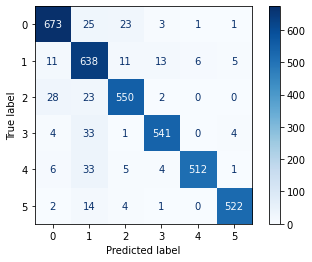

In [205]:
# https://www.jcchouinard.com/confusion-matrix-in-scikit-learn/
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

cm = confusion_matrix(y_test, y_test_predict)
plot_confusion_matrix(lr, x_test, y_test, cmap=plt.cm.Blues)
plt.show()

## Árvore de Decisão

In [199]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree